# MTH 496 HW2 

Due date: 5pm, Nov 1, 2022



In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mth

**&#9989; **Problem 1 (20pts)****.  Generate a dataset with 5 clusters (you can use sklearn.datasets.make blobs).
cluster it using k means clustering with k ranging from 1 to 10, and plot WCSS values against
k values.

In [15]:
#%matplotlib inline
#import seaborn as sns; sns.set() 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

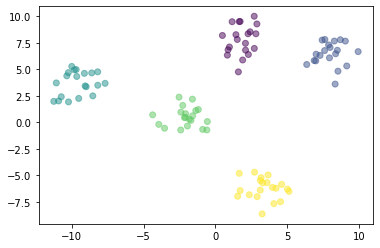

In [16]:
X, y = make_blobs(n_samples = 100, centers = 5, n_features=2, shuffle=True, random_state=20) # Generate Gaussian blobs for clustering.
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5) #did to check my blobs are clustered into 5 clusters, clearly works!

In [17]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X.data)
kmeans.cluster_centers_.shape

(10, 2)

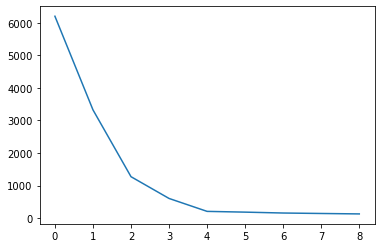

In [18]:
wcss = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state=0).fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(wcss)

**&#9989; **Problem 2 (40pts)****.  The MNIST datasets are given. Specifically, the training data sets
are MNIST X train.csv (features) and MNIST y train.csv (labels) and test data sets are
MNIST X test.csv (features) and MNIST y test.csv (labels). Program a SVM for Kernel
Classifiers (using the Lorentz kernel with ν = 2) to predict the labels of the test data. What
is the accuracy of your model?

In [19]:
mnist_x_test = pd.read_csv('MNIST_X_test.csv').values
mnist_x_train = pd.read_csv('MNIST_X_train.csv').values

mnist_y_test = pd.read_csv('MNIST_y_test.csv').values
mnist_y_train = pd.read_csv('MNIST_y_train.csv').values


In [20]:
from sklearn.preprocessing import LabelBinarizer, StandardScaler

In [21]:
def K(x,z):
    result = 1/(((1+(sum((x - z)**2))**0.5)/2)**2)
    return result

def SVM(X, y, epochs, lr, lam):
    b = 1.
    c = np.ones(X.shape[1])
    for epoch in range(epochs): 
        hinge_loss = 1. - y * (b + np.dot(X, c))
        hinge_loss[hinge_loss <= 1e-5] = 0 # hinge loss
        dc = - lam * np.dot(y[hinge_loss != 0], X[hinge_loss !=0]) + 2.*c
        db = - lam * np.sum(y[hinge_loss != 0])
        c -= lr * dc
        b -= lr * db
    return b, c 

def accuracy(ypred, yreal):
    return np.sum(ypred==yreal)/float(len(yreal))

In [22]:
print((mnist_x_train.shape))
print((mnist_y_train.shape))
print((mnist_x_test.shape))
print((mnist_y_test.shape))

mnist_y_train, mnist_y_test = mnist_y_train.flatten(), mnist_y_test.flatten()

lb = LabelBinarizer(neg_label=-1)
lb.fit(mnist_y_train)
ytrain_ohe = lb.transform(mnist_y_train)
ytest_ohe  = lb.transform(mnist_y_test)

(2000, 784)
(2000, 1)
(500, 784)
(500, 1)


In [23]:
scaler = StandardScaler().fit(mnist_x_train)
scaled_Xtrain = scaler.transform(mnist_x_train)
scaled_Xtest = scaler.transform(mnist_x_test)

epochs = 2000
lr = 0.01
lam = 10 # lambda
sigma = 10
      
preds = np.zeros((mnist_x_test.shape[0], 10))
# one vs all approach
for i in range(10):
    # Train class i vs rest
    b, c = SVM(scaled_Xtrain, ytrain_ohe[:,i], epochs, lr, lam)
    preds[:, i] = np.dot(scaled_Xtest, c)+b # labels is going to be used for prediction on test data
    pred_labels = np.dot(scaled_Xtrain, c)+b #do for train
    pred_labels[pred_labels < 0.] = -1
    pred_labels[pred_labels >= 0.] = 1 # pred_labels are the labels predicted on training data
    # compute training accuracy
    score = accuracy(ytrain_ohe[:,i], pred_labels)
    print("Training class {} vs all is complete. The training accuracy is {:.2f}%".format(i, score*100))

ypredictions_train = np.argmax(preds, axis=1)

score = accuracy(mnist_y_test, ypredictions_train)
print("The accuracy of multiclass classification is {:.2f}%".format(score*100))

a = np.array([0,1])
B = np.array([[0,1],[2,3]])
np.dot(a, B)

Training class 0 vs all is complete. The training accuracy is 99.90%
Training class 1 vs all is complete. The training accuracy is 99.40%
Training class 2 vs all is complete. The training accuracy is 94.20%
Training class 3 vs all is complete. The training accuracy is 97.25%
Training class 4 vs all is complete. The training accuracy is 99.75%
Training class 5 vs all is complete. The training accuracy is 99.25%
Training class 6 vs all is complete. The training accuracy is 98.65%
Training class 7 vs all is complete. The training accuracy is 92.10%
Training class 8 vs all is complete. The training accuracy is 96.30%
Training class 9 vs all is complete. The training accuracy is 97.25%
The accuracy of multiclass classification is 80.40%


array([2, 3])

In [24]:
scaler = StandardScaler().fit(mnist_x_train)
scaler.fit(mnist_x_train)
scaled_Xtrain = scaler.transform(mnist_x_train)
scaled_Xtest = scaler.transform(mnist_x_test)

epochs = 2000
lr = 0.01
lam = 10 # lambda
sigma = 10 

labels = np.zeros((mnist_x_test.shape[0], 10))
# one vs one approach
for i in range(9):
    for j in range(10):
        if j > i:
            data = scaled_Xtrain[(ytrain_ohe[:, i]==1)+(ytrain_ohe[:, j]==1)] # False+False=False
            target = ytrain_ohe[:,i][(ytrain_ohe[:, i]==1)+(ytrain_ohe[:, j]==1)]
            # Train class i vs class j
            b, c = SVM(data, target, epochs, lr, lam)
            
            labels_training_sets = np.dot(data, c)+b 
            labels_training_sets[labels_training_sets >=1e-5] = 1
            labels_training_sets[labels_training_sets < 1e-5] = -1 # labels predicted on training sets
            # compute training accuracy
            score = accuracy(target, labels_training_sets)
            print("Training class {} vs class {} is complete. The training accuracy is {:.2f}%".format(i,j,score*100))
            
            pred = np.dot(scaled_Xtest, c)+b
            labels[:, i][pred>=1e-5] += 1
            labels[:, j][pred<1e-5] += 1

ypredictions_test = np.argmax(labels, axis=1)

score = accuracy(mnist_y_test, ypredictions_test)
print("The accuracy of multiclass classification is {:.2f}%".format(score*100))

Training class 0 vs class 1 is complete. The training accuracy is 100.00%
Training class 0 vs class 2 is complete. The training accuracy is 100.00%
Training class 0 vs class 3 is complete. The training accuracy is 100.00%
Training class 0 vs class 4 is complete. The training accuracy is 100.00%
Training class 0 vs class 5 is complete. The training accuracy is 100.00%
Training class 0 vs class 6 is complete. The training accuracy is 100.00%
Training class 0 vs class 7 is complete. The training accuracy is 100.00%
Training class 0 vs class 8 is complete. The training accuracy is 96.30%
Training class 0 vs class 9 is complete. The training accuracy is 100.00%
Training class 1 vs class 2 is complete. The training accuracy is 100.00%
Training class 1 vs class 3 is complete. The training accuracy is 100.00%
Training class 1 vs class 4 is complete. The training accuracy is 100.00%
Training class 1 vs class 5 is complete. The training accuracy is 100.00%
Training class 1 vs class 6 is complete

**&#9989; **Problem 3 (40pts)****.  The airfoil datasets are given. Specifically, the training data sets are
airfoil self noise X train.csv (features) and airfoil self noise y train.csv (labels)
and test data sets are airfoil self noise X test.csv (features) and
airfoil self noise y test.csv. Program regression decision trees and random forest (re-
gression version) to predict the labels of the test data. Print Pearson correlation coefficient
and RMSE of your models.

In [40]:
airfoil_x_test = pd.read_csv('airfoil_self_noise_X_test.csv')
airfoil_x_train = pd.read_csv('airfoil_self_noise_X_train.csv')

airfoil_y_test = pd.read_csv('airfoil_self_noise_y_test.csv')
airfoil_y_train = pd.read_csv('airfoil_self_noise_y_train.csv')

def normalize_features(X_train, X_test):
    scaler = StandardScaler() 
    scaler.fit(X_train)
    X_train_norm = scaler.transform(X_train) 
    X_test_norm = scaler.transform(X_test) 
    return X_train_norm, X_test_norm

normalize_features(airfoil_x_train, airfoil_x_test)

(array([[ 1.62339044, -1.13736344,  0.17273637, -1.21636295, -0.68169974],
        [-0.75660293, -0.79668017,  0.99124798, -1.21636295, -0.55819346],
        [-0.51860359, -1.13736344, -0.91861245, -0.70594096, -0.78039108],
        ...,
        [-0.40753723,  0.29350629, -0.91861245,  1.34220806, -0.43910022],
        [-0.51860359, -1.13736344, -1.19144966, -1.21636295, -0.80709447],
        [-0.51860359, -0.21751861,  0.17273637, -0.70594096, -0.47281386]]),
 array([[-0.66140319, -1.13736344,  1.8097596 ,  1.34220806, -0.63855295],
        [ 1.62339044, -1.13736344,  1.8097596 ,  1.34220806, -0.63855295],
        [-0.71534971, -1.13736344,  1.8097596 ,  0.32136407, -0.62586325],
        ...,
        [-0.81530943,  1.51996605, -0.37293804,  1.34220806,  2.47343383],
        [-0.71534971,  1.51996605, -0.37293804,  1.34220806,  2.47343383],
        [-0.5979367 ,  1.51996605, -0.37293804, -0.70594096,  3.16481921]]))

In [41]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=5, current_depth=1, max_features=None):        
        self.max_depth = max_depth
        self.current_depth = current_depth
        self.left_tree = None
        self.right_tree = None
        self.max_features = max_features
        
    def fit(self, X, y):
        self.X = X
        self.y = y        
        self.n_features = X.shape[1]
        self.n_samples = X.shape[0]
        if self.current_depth <= self.max_depth:
            self.GINI = self.GINI_calculation(self.y)
            self.best_feature_id, self.best_gain, self.best_split_value = self.find_best_split()
            if self.best_gain > 0:
                self.split_trees()
    
    def split_trees(self):
        # create a left tree
        self.left_tree = DecisionTreeClassifier(max_depth=self.max_depth, current_depth=self.current_depth + 1)
        self.right_tree = DecisionTreeClassifier(max_depth=self.max_depth, current_depth=self.current_depth + 1)
        # partition X according to self.best_split_value and self.best_feature_id
        best_feature_values = self.X[:, self.best_feature_id]
        left_indices = np.where(best_feature_values < self.best_split_value)
        right_indices = np.where(best_feature_values >= self.best_split_value)
        left_tree_X, left_tree_y = self.X[left_indices], self.y[left_indices]
        right_tree_X, right_tree_y = self.X[right_indices], self.y[right_indices]
        # fit left and right tree
        self.left_tree.fit(left_tree_X, left_tree_y)
        self.right_tree.fit(right_tree_X, right_tree_y)    
    
    def find_best_split(self):
        best_feature_id = None
        best_gain = 0
        best_split_value = None
        if self.max_features is None:
            for feature_id in range(self.n_features): # search best_split_value for each feature_id and keep the best one
                current_gain, current_split_value = self.find_best_split_one_feature(feature_id)
                if current_gain is None:
                    continue
                if best_gain < current_gain:
                    best_feature_id = feature_id
                    best_gain = current_gain                
                    best_split_value = current_split_value
        elif self.max_features == 'sqrt':
            rng = np.random.default_rng()
            sampled_features = rng.choice(self.X.shape[1], int(np.sqrt(self.X.shape[1])), replace=False)
            for feature_id in sampled_features: # search best_split_value for each feature_id and keep the best one
                current_gain, current_split_value = self.find_best_split_one_feature(feature_id)
                if current_gain is None:
                    continue
                if best_gain < current_gain:
                    best_feature_id = feature_id
                    best_gain = current_gain                
                    best_split_value = current_split_value    
        return best_feature_id, best_gain, best_split_value
    
    def find_best_split_one_feature(self, feature_id):
        '''
            Return information_gain, split_value
        '''
        feature_values = self.X[:, feature_id]
        unique_feature_values = np.unique(feature_values)
        best_gain = 0.0
        best_split_value = None
        if len(unique_feature_values) == 1:
            return best_gain, best_split_value
        for fea_val in unique_feature_values:
            left_indices, right_indices = np.where(feature_values < fea_val), np.where(feature_values >= fea_val)
            left_tree_X, left_tree_y = self.X[left_indices], self.y[left_indices]
            right_tree_X, right_tree_y = self.X[right_indices], self.y[right_indices]
            left_GINI, right_GINI = self.GINI_calculation(left_tree_y), self.GINI_calculation(right_tree_y)
            left_n_samples, right_n_samples = left_tree_X.shape[0], right_tree_X.shape[0]
            current_gain = self.GINI - (left_n_samples/self.n_samples * left_GINI + right_n_samples/self.n_samples * right_GINI)
            if best_gain < current_gain:
                best_gain = current_gain
                best_split_value = fea_val
        return best_gain, best_split_value                                    
            
    def GINI_calculation(self, y):
        if y.size == 0 or y is None:
            return 0.0
        unique, counts = np.unique(y, return_counts=True)
        prob = counts/y.size # proportions of counts in y
        return 1.0 - np.sum(prob*prob)

    def predict(self, X_test):
        n_test = X_test.shape[0]
        ypred = np.zeros(n_test, dtype=int)  
        for i in range(n_test):
            ypred[i] = self.tree_propogation(X_test[i])            
        return ypred

    def tree_propogation(self, feature):
        if self.is_leaf_node():
            return self.predict_label()
        if feature[self.best_feature_id] < self.best_split_value:
            child_tree = self.left_tree
        else:
            child_tree = self.right_tree
        return child_tree.tree_propogation(feature)

    def predict_label(self):
        unique, counts = np.unique(self.y, return_counts=True)
        return unique[np.argmax(counts)]
    
    def is_leaf_node(self):
        return self.left_tree is None

def accuracy(ypred, yexact):
    p = np.array(ypred == yexact, dtype = int)
    return np.sum(p)/float(len(yexact))


In [42]:
from DecisionTreeClassifier import * 
import scipy

class random_forest_regressor:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.forest = []
        for i in range(self.n_estimators):
            self.forest.append(DecisionTreeClassifier(max_depth=10, max_features='sqrt'))

    def fit(self, X, y):
        '''bagging'''
        self.X = X
        self.y = y
        self.N = X.shape[1]
        self.M = X.shape[0]

        self.trees_idx = np.random.randint(0, self.M, size=(self.n_estimators, self.M))
        for i, itree in enumerate(self.forest):
            itree.fit(self.X[self.trees_idx[i]], self.y[self.trees_idx[i]])
            print("The {}th tree is built".format(i))

    def predict(self, Xtest):
        n_test = Xtest.shape[0]
        ypred = np.zeros((self.n_estimators, n_test))
        for i, itree in enumerate(self.forest):
            ypred[i, :] = itree.predict(Xtest)
        return scipy.stats.mode(ypred, axis=0)[0].flatten()


In [43]:
airfoil_x_test = pd.read_csv('airfoil_self_noise_X_test.csv').values
airfoil_x_train = pd.read_csv('airfoil_self_noise_X_train.csv').values

airfoil_y_test = pd.read_csv('airfoil_self_noise_y_test.csv').values
airfoil_y_train = pd.read_csv('airfoil_self_noise_y_train.csv').values

airfoil_y_train, airfoil_y_test = airfoil_y_train.flatten(), airfoil_y_test.flatten()

RF = random_forest_regressor(n_estimators=10)
RF.fit(airfoil_x_train, airfoil_y_train)

y_predictions = RF.predict(airfoil_x_test)
# Calculate the absolute errors
errors = abs(y_predictions - airfoil_y_test)

mape = 100 * (errors / airfoil_y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy of model:', round(accuracy, 2), '%.')


MSE = np.square(np.subtract(airfoil_y_test,y_predictions)).mean() 
RMSE = mth.sqrt(MSE)
print("Root Mean Square Error(RMSE):\n")
print(RMSE)


pearson = np.corrcoef(airfoil_y_test, y_predictions)
print(pearson,' which is the correlation matrix, These equal values represent the Pearson correlation coefficient for x and y. approximately 0.56') 

The 0th tree is built
The 1th tree is built
The 2th tree is built
The 3th tree is built
The 4th tree is built
The 5th tree is built
The 6th tree is built
The 7th tree is built
The 8th tree is built
The 9th tree is built
Accuracy of model: 95.77 %.
Root Mean Square Error(RMSE):

7.0834619138091925
[[1.         0.50829566]
 [0.50829566 1.        ]]  which is the correlation matrix, These equal values represent the Pearson correlation coefficient for x and y. approximately 0.56
